In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox

ModuleNotFoundError: No module named 'osmnx'

### OSMnx

In [ ]:
### get Butte county boundary
ca_counties = gpd.read_file('network_inputs/ca-county-boundaries/CA_Counties/CA_Counties_TIGER2016.shp')
butte = ca_counties[ca_counties['NAME']=='Butte']
butte.plot()

In [ ]:
### Download and clean data using OSMnx: drive and service
# butte_g = ox.graph_from_polygon(butte.to_crs('epsg:4326')['geometry'].iloc[0], network_type='drive_service')

### Download and clean data using OSMnx: drive only
butte_g = ox.graph_from_polygon(butte.to_crs('epsg:4326')['geometry'].iloc[0], network_type='drive')
# butte_g = ox.utils_graph.get_largest_component(butte_g, strongly=True)

In [ ]:
butte_g2 = ox.utils_graph.get_largest_component(butte_g, strongly=True)
# butte_g3 = ox.simplification.simplify_graph(butte_g2, strict=True, remove_rings=True)

In [ ]:
### Nodes and Edges GDF
### Drive and service: (17220, 6) (41841, 17)
### Drive only: (13746, 6) (33077, 15)
butte_nodes, butte_edges = ox.graph_to_gdfs(butte_g2)
print(butte_nodes.shape, butte_edges.shape)
# butte_nodes.to_csv('network_inputs/butte_nodes_drive.csv', index=False)
# butte_edges.to_csv('network_inputs/butte_edges_drive.csv', index=False)

In [ ]:
butte_edges[butte_edges['u']==butte_edges['v']]

In [ ]:
### add id to node
butte_nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
# butte_nodes = pd.read_csv('network_inputs/butte_ctm_nodes.csv')
butte_nodes['nid'] = np.arange(butte_nodes.shape[0])
butte_nodes['lon'] = butte_nodes['x']
butte_nodes['lat'] = butte_nodes['y']
butte_nodes[['nid', 'osmid', 'lon', 'lat']].to_csv('network_inputs/butte_nodes_sim.csv', index=False)
# butte_nodes[['nid', 'osmid', 'lon', 'lat']].to_csv('network_inputs/butte_ctm_nodes_sim.csv', index=False)
### Further process
butte_edges = pd.read_csv('network_inputs/butte_edges_drive.csv')
# butte_edges = pd.read_csv('network_inputs/butte_ctm_edges_manual.csv')
# butte_edges['geometry'] = butte_edges['WKT']
butte_edges.head()
butte_edges['type'] = butte_edges['highway']
butte_edges['type'] = np.where(butte_edges['highway']=="['residential', 'tertiary']", 'residential', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['trunk', 'motorway']", 'motorway', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['tertiary', 'unclassified']", 'unclassified', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['residential', 'unclassified']", 'unclassified', butte_edges['type'])
# butte_edges['type'].unique()
### max speed
butte_edges['maxmph'] = 25*0.8
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['motorway', 'motorway_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['trunk', 'trunk_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['primary', 'primary_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['secondary', 'secondary_link']), 25, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['tertiary', 'tertiary_link']), 25, butte_edges['maxmph'])
### lanes
butte_edges['lanes'] = 1
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['motorway', 'motorway_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['trunk', 'trunk_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['primary', 'primary_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['secondary', 'secondary_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['tertiary', 'tertiary_link']), 2, butte_edges['lanes'])
### edge_id, start and end node
butte_edges['eid'] = np.arange(butte_edges.shape[0])
butte_edges = butte_edges.merge(butte_nodes[['nid', 'osmid']], how='left', left_on='u', right_on='osmid')
butte_edges = butte_edges.merge(butte_nodes[['nid', 'osmid']], how='left', left_on='v', right_on='osmid', suffixes=['_s', '_e'])
butte_edges[['eid', 'nid_s', 'nid_e', 'type', 'length', 'maxmph', 'lanes', 'geometry']].to_csv('network_inputs/butte_edges_sim.csv', index=False)
# butte_edges[['eid', 'nid_s', 'nid_e', 'length', 'maxmph', 'lanes', 'geometry']].to_csv('network_inputs/butte_ctm_edges_sim.csv', index=False)

### CTM

In [ ]:
from shapely.geometry import Point
from collections import Counter

### Load nodes and eges
butte_nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
butte_nodes = gpd.GeoDataFrame(butte_nodes, crs='epsg:4326', geometry=[Point(xy) for xy in zip(butte_nodes.x, butte_nodes.y)])
butte_edges = pd.read_csv('network_inputs/butte_edges_drive.csv')

In [ ]:
### Read city boundary
ca_cities = gpd.read_file('ca-places-boundaries/CA_Places_TIGER2016.shp')
paradise = ca_cities.loc[ca_cities['NAMELSAD']=='Paradise town', 'geometry'].to_crs('epsg:3857').buffer(300).to_crs('epsg:4326').iloc[0]

spatial_index = butte_nodes.sindex
possible_matches_index = list(spatial_index.intersection(paradise.bounds))
possible_matches = butte_nodes.iloc[possible_matches_index]
paradise_nodes = possible_matches[possible_matches.intersects(paradise)].reset_index(drop=True)
# paradise_nodes.to_csv('network_inputs/paradise_nodes.csv', index=False)
# display(paradise_nodes.head())

regional_route_files = ['skyway_nodes', 'neal_nodes', 'clark_nodes', 'pentz_nodes', 'CA70_nodes', 'CA70_oroville_nodes', 'CA149_nodes']
regional_nodes_list = []
for file in regional_route_files:
    regional_route_nodes = pd.read_csv('network_inputs/{}.csv'.format(file))
    regional_nodes_list.append(regional_route_nodes)
regional_nodes = pd.concat(regional_nodes_list)

potential_ctm_nodes = list(set(
    paradise_nodes['osmid'].values.tolist() + 
    regional_nodes['osmid'].values.tolist()))

### Remove small branch roads
undirected_nodes = pd.DataFrame(np.sort(butte_edges[['u', 'v']].values, axis=1), columns=[['u', 'v']]).drop_duplicates()
node_counts = Counter(undirected_nodes.values.flatten().tolist())
single_count_nodes = [n for n, v in node_counts.items() if v==1]
# print(len(node_counts), len(single_count_nodes))

# ### keep type
ctm_edges = butte_edges.copy().loc[
    ~(butte_edges['highway'].isin(['residential', 'living_street']) & (
        (butte_edges['u'].isin(single_count_nodes)) |
        (butte_edges['v'].isin(single_count_nodes)))
     ) & (
    butte_edges['u'].isin(potential_ctm_nodes)) & (
    butte_edges['v'].isin(potential_ctm_nodes))]
ctm_edges.to_csv('network_inputs/butte_ctm_edges.csv', index=False)
ctm_edges.shape

In [ ]:
### Assign zones to CTM nodes
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import Point
import reduce_network_util

### extract CTM node from manually selected CTM edges
ctm_edges = pd.read_csv('network_inputs/butte_ctm_edges_manual.csv')
ctm_edges = ctm_edges.rename(columns={'WKT': 'geometry'})
ctm_nodes_list = np.unique(ctm_edges['u'].values.tolist() + ctm_edges['v'].values.tolist())
print(len(ctm_nodes_list), ctm_nodes_list[0:6])

### CTM nodes gdf
nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
nodes = gpd.GeoDataFrame(nodes, geometry=[Point(xy) for xy in zip(nodes.x, nodes.y)], crs='epsg:4326').to_crs('epsg:3857')
ctm_nodes = nodes[nodes['osmid'].isin(ctm_nodes_list)].reset_index(drop=True)

### clean the network
nodes_no_stag, edges_no_stag = reduce_network_util.remove_stag_nodes(ctm_nodes, ctm_edges, iteration=20)
nodes_remain, edges_remain = reduce_network_util.remove_false_intersections(nodes_no_stag, edges_no_stag)
nodes_long, edges_long = reduce_network_util.short_elements_to_nodes(nodes_remain, edges_remain)
nodes_no_stag, edges_no_stag = reduce_network_util.remove_stag_nodes(nodes_long, edges_long)
nodes_remain, edges_remain = reduce_network_util.remove_false_intersections(nodes_no_stag, edges_no_stag)

### populate node attributes
nodes = nodes_remain[['x', 'y', 'osmid']].copy()
nodes['type'] = 'real'
nodes['node_id'] = np.arange(nodes.shape[0])
nodes = nodes.rename(columns={'x': 'lon', 'y': 'lat', 'node_id': 'nid'})
display(nodes[['nid', 'lon', 'lat', 'type', 'osmid']].head())
nodes[['nid', 'lon', 'lat', 'type', 'osmid']].to_csv('network_inputs/butte_simplified_ctm_nodes.csv', index=False)

### populate edge attributes
edges = edges_remain[['u', 'v', 'highway', 'geometry']].copy()
edges['link_id'] = np.arange(edges.shape[0])
edges = edges.rename(columns={'link_id': 'eid', 'u': 'start_osmid', 'v': 'end_osmid', 'highway': 'type'})
# edges['start_osmid'] = edges['start_osmid'].astype('str')
edges = edges.merge(nodes[['osmid', 'nid']], how='left', left_on='start_osmid', right_on='osmid').merge(nodes[['osmid', 'nid']], how='left', left_on='end_osmid', right_on='osmid', suffixes=['_s', '_e'])
print(edges['type'].unique())

# ### max speed
edges['maxmph'] = 25*0.8
edges['maxmph'] = np.where(edges['type'].isin(['motorway', 'motorway_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['trunk', 'trunk_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['primary', 'primary_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['secondary', 'secondary_link']), 25, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['tertiary', 'tertiary_link']), 25, edges['maxmph'])

# ### lanes
edges['lanes'] = 1
edges['lanes'] = np.where(edges['type'].isin(['motorway', 'motorway_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['trunk', 'trunk_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['primary', 'primary_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['secondary', 'secondary_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['tertiary', 'tertiary_link']), 2, edges['lanes'])

# ### capacity
edges['capacity'] = edges['lanes']*1900
### fft
edges = gpd.GeoDataFrame(edges, crs='epsg:4326', geometry=edges['geometry'].apply(loads))
edges['length'] = edges['geometry'].to_crs('epsg:3857').length
edges['fft'] = edges['length']/edges['maxmph'] * 2.23694

edges = edges[['eid', 'nid_s', 'nid_e', 'type', 'length', 'maxmph', 'lanes', 'capacity', 'fft', 'start_osmid', 'end_osmid', 'geometry']]
display(edges.head())
edges.to_csv('network_inputs/butte_simplified_ctm_edges.csv', index=False)

## read evacuation zone file
evac_zones = gpd.read_file('demand_inputs/digitized_evacuation_zone/digitized_evacuation_zone.shp').to_crs('epsg:3857')
nodes = gpd.GeoDataFrame(nodes, geometry=[Point(xy) for xy in zip(nodes.lon, nodes.lat)], crs='epsg:4326').to_crs('epsg:3857')
nodes_sindex = nodes.sindex
nodes['evac_zone'] = -1

for zone in evac_zones.itertuples():
    zone_id = getattr(zone, 'id')
    zone_geom = getattr(zone, 'geometry').buffer(10) ### a small buffer to cover nodes in the gap of zones
    coarse_node_ids = list(nodes_sindex.intersection(zone_geom.bounds))
    coarse_nodes = nodes.iloc[coarse_node_ids]
    precise_nodes = coarse_nodes[coarse_nodes.intersects(zone_geom)]
    nodes['evac_zone'] = np.where(nodes['osmid'].isin(
        precise_nodes['osmid']), zone_id, nodes['evac_zone'])

nodes.groupby('evac_zone').size().head()
nodes.to_crs('epsg:4326').to_csv('network_inputs/butte_simplified_ctm_nodes_zones.csv', index=False)

In [ ]:
### Assign speed etc to CTM edges

### Demand

In [2]:
import random 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 

from shapely import wkt 
from shapely.geometry import Point

from datetime import datetime, timedelta
import matplotlib.dates as mdates

In [3]:
def nodes_in_polygon(nodes_gdf, nodes_sindex, polygon):
    coarse_node_ids = list(nodes_sindex.intersection(polygon.bounds))
    coarse_nodes = nodes_gdf.iloc[coarse_node_ids]
    precise_nodes = coarse_nodes[coarse_nodes.intersects(polygon)]
    return precise_nodes

def get_closest_node(gdf1=None, geom_col1=None, gdf2=None, geom_col2=None, id_col2=None):
    gdf1['x'] = gdf1[geom_col1].x
    gdf1['y'] = gdf1[geom_col1].y
    node1_xy = gdf1[['x', 'y']].values
    
    gdf2['x'] = gdf2[geom_col2].x
    gdf2['y'] = gdf2[geom_col2].y
    node2_xy = gdf2[['x', 'y']].values
    
    distance_matrix = cdist(node1_xy, node2_xy)
    closest_array = distance_matrix.argmin(axis=1)
    return gdf2[id_col2].values[closest_array]

In [4]:
### node file
# nodes_df = pd.read_csv('network_inputs/butte_simplified_ctm_nodes.csv')
nodes_df = pd.read_csv('network_inputs/butte_nodes_sim.csv')
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=[Point(xy) for xy in zip(nodes_df.lon, nodes_df.lat)], crs='epsg:4326').to_crs('epsg:3857')

### city boundary
cities = gpd.read_file('network_inputs/ca-places-boundaries/CA_Places_TIGER2016.shp').to_crs('epsg:3857')
### individual cities
paradise = cities[cities['NAMELSAD']=='Paradise town'].copy()
magalia = cities[cities['NAMELSAD']=='Magalia CDP'].copy()
chico = cities[cities['NAMELSAD']=='Chico city'].copy()
oroville = cities.loc[cities['NAME'].isin(['Palermo', 'Oroville East', 'South Oroville', 'Kelly Ridge', 'Oroville', 'Thermalito'])].copy()

### get nodes in chico and oroville
nodes_sindex = nodes_gdf.sindex
# print(chico.unary_union)
chico_nodes_gdf = nodes_in_polygon(nodes_gdf, nodes_sindex, chico.unary_union.buffer(100))
oroville_nodes_gdf = nodes_in_polygon(nodes_gdf, nodes_sindex, oroville.unary_union.buffer(100))

### parcel file
parcels = gpd.read_file('demand_inputs/BCAG_GIS_Request/parcel/parcel.shp').to_crs('epsg:3857')

### evacuation zone
evac_zones = gpd.read_file('demand_inputs/digitized_evacuation_zone/digitized_evacuation_zone.shp').to_crs('epsg:3857')
evac_zones_test = evac_zones.loc[evac_zones['id']<=14].copy()
evac_zones_test.to_crs('epsg:3857')['geometry'].unary_union.area/1e6

90.89957966542352

In [5]:
### Residential parcels in Paradise
### did not consider Magalia and needs to be changed in the future
### did not consider all land use types

### While the pre-fire population of Paradise was an estimated 26,800, according to the U.S. 2010 Census, a door-to-door survey conducted in April of this year revealed only 2,034 residents remain
### https://sf.curbed.com/2019/7/12/20692079/town-destroyed-by-pg-e-fire-loses-92-percent-of-its-population
paradise_parcels = parcels.loc[(parcels['JURISDICTI']=='Paradise') & (parcels['LANDUSE'].isin(['RZ', 'RV', 'RS']))].copy().reset_index(drop=True)
magalia_parcels = parcels.loc[~parcels['CityStZIP'].isnull()].copy().reset_index(drop=True)
magalia_parcels = magalia_parcels.loc[(magalia_parcels['CityStZIP'].apply(lambda x: x[0:7])=='MAGALIA') & (magalia_parcels['LANDUSE'].isin(['RZ', 'RV', 'RS']))].copy().reset_index(drop=True)
paradise_magalia_parcels = pd.concat([paradise_parcels, magalia_parcels])
paradise_magalia_parcels.groupby('LANDUSE').size()

LANDUSE
RS    4349
RV     837
RZ    7138
dtype: int64

In [6]:
tmp = evac_zones.copy()
tmp['area'] = evac_zones.area
display(tmp.head())
display(tmp.area.to_frame('area'))
tmp = tmp.merge(paradise_magalia_parcels.groupby('evac_zone').size().to_frame('hh_cnts').reset_index(), how='left', left_on='id', right_on='evac_zone')
tmp['hh_density'] = tmp['hh_cnts']/tmp['area']*1609**2
tmp

,id,zone_name,geometry,area
0,1,Zone_1,"POLYGON ((-13534396.635 4837121.992, -13534333...",1.222967e+07
1,2,Zone_2,"POLYGON ((-13534810.587 4836326.942, -13534440...",6.150279e+06
2,3,Zone_3,"POLYGON ((-13534323.934 4836980.728, -13534165...",1.069241e+07
3,4,Zone_4,"POLYGON ((-13540473.666 4832648.124, -13537552...",7.880984e+06
4,5,Zone_5,"POLYGON ((-13537550.602 4832619.257, -13535948...",5.864116e+06


,area
0,1.222967e+07
1,6.150279e+06
2,1.069241e+07
3,7.880984e+06
4,5.864116e+06
5,3.310093e+06
6,4.869323e+06
7,6.102598e+06
8,4.637043e+06
9,5.194019e+06


KeyError: 'evac_zone'

In [7]:
### Match each parcel to a zone and a node
paradise_magalia_parcels['centroid'] = paradise_magalia_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
paradise_magalia_parcels = paradise_magalia_parcels.set_geometry('centroid')
paradise_magalia_parcels_sindex = paradise_magalia_parcels.sindex
paradise_magalia_parcels['evac_zone'] = -1

for zone in evac_zones.itertuples():
    zone_id = getattr(zone, 'id')
    zone_geom = getattr(zone, 'geometry').buffer(10) ### a small buffer to cover nodes at the boundaries
    precise_parcels = nodes_in_polygon(paradise_magalia_parcels, paradise_magalia_parcels_sindex, zone_geom)
    paradise_magalia_parcels['evac_zone'] = np.where(paradise_magalia_parcels['APN'].isin(
        precise_parcels['APN']), zone_id, paradise_magalia_parcels['evac_zone'])
paradise_magalia_parcels.to_crs('epsg:4326').to_csv('demand_inputs/paradise_magalia_parcels_labeled.csv', index=False)
display(paradise_magalia_parcels.groupby('evac_zone').size().to_frame('hh_cnts').head())

### Map residential parcels in Paradise to nodes
paradise_magalia_parcels['closest_node'] = get_closest_node(gdf1=paradise_magalia_parcels, geom_col1='centroid', gdf2=nodes_gdf, geom_col2='geometry', id_col2='osmid')
display(paradise_magalia_parcels[['APN', 'evac_zone', 'closest_node']].head())

,hh_cnts
evac_zone,
-1,2103
1,1082
2,1014
3,886
4,1211


,APN,evac_zone,closest_node
0,050-011-012-000,1,86406781
1,050-011-013-000,1,86406781
2,050-011-022-000,1,86432131
3,050-011-024-000,1,86432131
4,050-011-025-000,1,86518494


(21607, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86454839,86615384,3600,11,055-111-002-000,0
1,86454839,86615384,3600,11,055-111-002-000,1


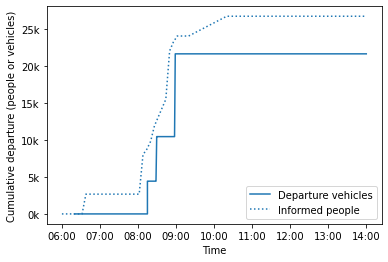

(21607, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86454839,86544036,3516,11,055-111-002-000,0
1,86454839,86544036,3516,11,055-111-002-000,1


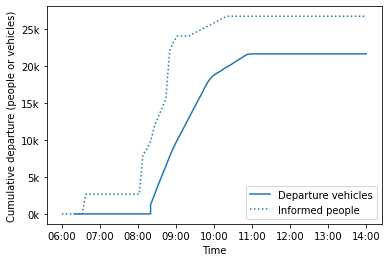

(12324, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86454839,86615384,3600,11,055-111-002-000,0
1,86448297,86451340,3600,-1,064-550-019-000,0


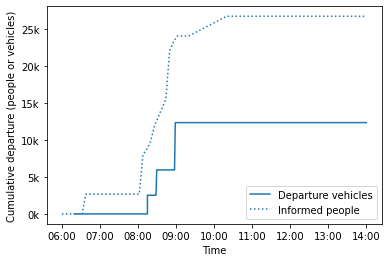

(12324, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86454839,86544036,3516,11,055-111-002-000,0
1,86448297,2709820505,1227,-1,064-550-019-000,0


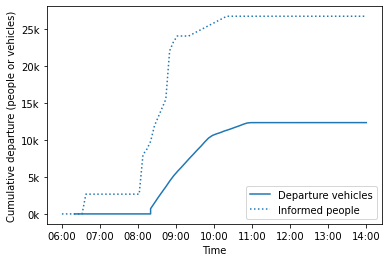

(24648, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86454839,86615384,3600,11,055-111-002-000,0
1,86454839,86615384,3600,11,055-111-002-000,1


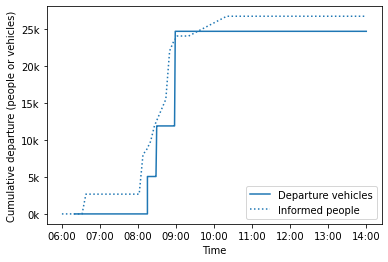

(24648, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86454839,86544036,3516,11,055-111-002-000,0
1,86454839,86544036,3516,11,055-111-002-000,1


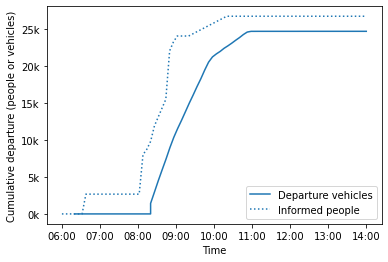

(21624, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86554213,86497031,1800,2,051-145-010-000,0
1,86417990,86512181,1800,6,053-104-024-000,0


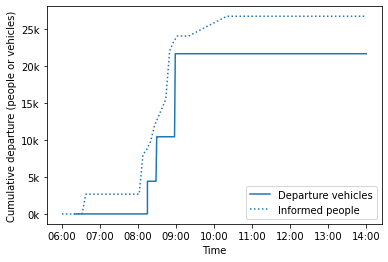

(21624, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86554213,86439854,3373,2,051-145-010-000,0
1,86417990,86561237,2847,6,053-104-024-000,0


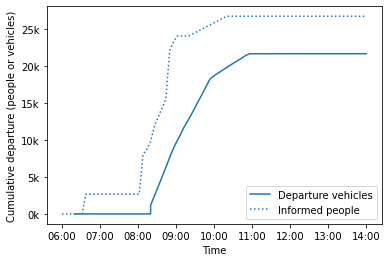

(12324, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86554213,86497031,1800,2,051-145-010-000,0
1,86417990,86512181,1800,6,053-104-024-000,0


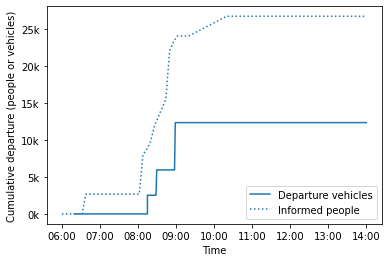

(12324, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86554213,86439854,3373,2,051-145-010-000,0
1,86417990,86561237,2847,6,053-104-024-000,0


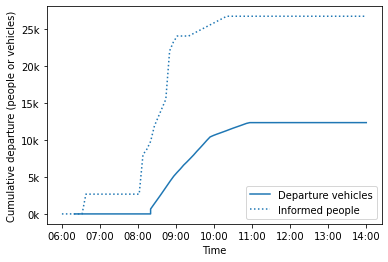

(24648, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86554213,86497031,1800,2,051-145-010-000,0
1,86554213,86497031,1800,2,051-145-010-000,1


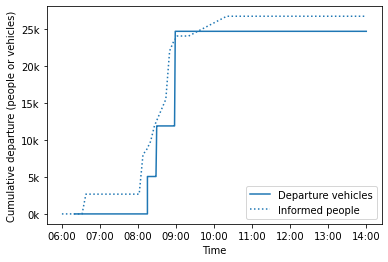

(24648, 6)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18]


,origin_osmid,destin_osmid,dept_time,evac_zone,APN,v_id
0,86554213,86439854,3373,2,051-145-010-000,0
1,86554213,86439854,3373,2,051-145-010-000,1


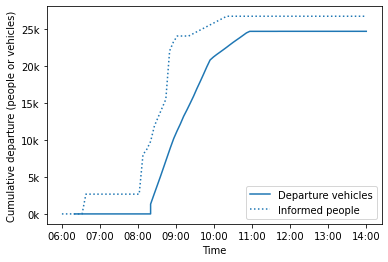

In [8]:
for random_seed in [15, 20]:
    for vphh_id in ['123', '1', '2']:
        for dept_id in ['1', '2']:

            # random seed
            random.seed(random_seed)
            np.random.seed(random_seed)
            parcel_od = paradise_magalia_parcels.copy()
            parcel_od = parcel_od.sample(frac=1)

            # assign vehicles per household
            if vphh_id == '1':
                parcel_od['veh_cnt'] = 1
            elif vphh_id == '2':
                parcel_od['veh_cnt'] = 2
            elif vphh_id == '123':
                parcel_od['veh_cnt'] = np.random.choice([1,2,3], p=[0.4, 0.45, 0.15], size=parcel_od.shape[0])
            else:
                print('vphh scenario undefined')

            # assign departure time
            if dept_id == '0':
                parcel_od['dept_time'] = 0
            elif dept_id == '1':
                parcel_od['dept_time'] = np.where(parcel_od['evac_zone'].isin([3, 8, 4]), 15*60, 
                                        np.where(parcel_od['evac_zone'].isin([2, 6, 7, 13]), 30*60, 3600))
            elif dept_id == '2':
                parcel_od['dept_time'] = random.choices(
                    range(20*60, 1*3600), k=int(parcel_od.shape[0]*0.4)) + random.choices(
                    range(1*3600, 2*3600), k=int(parcel_od.shape[0]*0.45)) + random.choices(
                    range(2*3600, 3*3600), k=int(parcel_od.shape[0]*0.15)) + random.choices(
                    range(3*3600, 6*3600), k=parcel_od.shape[0] - int(parcel_od.shape[0]*0.4) - int(parcel_od.shape[0]*0.45) - int(parcel_od.shape[0]*0.15))
                
            # assign destination
            chico_ratio = 0.7
            parcel_od['destin_osmid'] = random.choices(
                chico_nodes_gdf['osmid'].values.tolist(), k=int(parcel_od.shape[0]*chico_ratio)) + random.choices(
                oroville_nodes_gdf['osmid'].values.tolist(), k=parcel_od.shape[0]-int(parcel_od.shape[0]*chico_ratio))

            ### make OD
            od_list = []
            for parcel in parcel_od.itertuples():
                for veh_id in range(getattr(parcel, 'veh_cnt')):
                    od_list.append([getattr(parcel, 'closest_node'), getattr(parcel, 'destin_osmid'), getattr(parcel, 'dept_time'), getattr(parcel, 'evac_zone'), getattr(parcel, 'APN'), veh_id])
            od = pd.DataFrame(od_list, columns=['origin_osmid', 'destin_osmid', 'dept_time', 'evac_zone', 'APN', 'v_id'])
            ### only look at the first 14 zones
            # od = od.loc[od['evac_zone']<=14]

            print(od.shape)
            print(np.unique(od['evac_zone']))
            display(od.head(2))

            ### notification curve
            communication_time = [-0.33] + list(np.arange(0, 4.2, 0.1))
            communitation_population = [0, 0, 0, 0, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 2668.2, 8004.6, 8716.12, 9783.4, 11873.49, 13074.18, 14274.87, 15475.56, 22012.65, 23213.34, 24013.8, 24013.8, 24013.8, 24013.8, 24280.62, 24547.44, 24814.26, 25081.08, 25347.9, 25614.72, 25881.54, 26148.36, 26415.18, 26682, 26682]

            def second_to_datetime(l):
                return [datetime(100,1,1,8,0,0) + timedelta(minutes=t) for t in l]

            # plot
            fig, ax = plt.subplots()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
            # plot cumulative departure
            values, base = np.histogram(od['dept_time'], bins=40)
            departure_time_plot = second_to_datetime([-100, np.min(od['dept_time'])/60] + list(base[:-1]/60) + [360])
            cumulative = np.cumsum(values)
            ax.plot(departure_time_plot, [0, 0] + list(cumulative) + [np.max(cumulative)], ls='-', label='Departure vehicles')
            # notification plot
            communication_time_plot = second_to_datetime([60*t-100 for t in communication_time] + [360])
            ax.plot(communication_time_plot, communitation_population + [np.max(communitation_population)], c='C0', ls=':', label='Informed people')

            ax.set_xlabel('Time')
            ax.set_ylabel('Cumulative departure (people or vehicles)')
            ax.set_yticks(np.arange(0, 30000, 5000))
            ax.set_yticklabels(['{}k'.format(int(y/1000)) for y in ax.get_yticks().tolist()])
            plt.legend()
            plt.show()

            # # od[['origin_osmid', 'destin_osmid', 'evac_zone', 'hh_id', 'v_id', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']].to_csv('demand_inputs/od.csv', index=False)
            od.to_csv('demand_inputs/od_r{}_vphh{}_dept{}.csv'.format(random_seed, vphh_id, dept_id), index=False)

In [ ]:
### CTM
### assume 100% of evacuee
evac_pct = 1
### assume 2 veh per household
vphh = 2

### make OD
od_list = []
for parcel in paradise_parcels[['APN', 'evac_zone', 'closest_node']].copy().sample(frac=evac_pct).itertuples():
    for v_id in range(vphh):
        od_list.append([getattr(parcel, 'APN'), v_id, getattr(parcel, 'evac_zone'), getattr(parcel, 'closest_node')])
od = pd.DataFrame(od_list, columns=['APN', 'v_id', 'evac_zone', 'origin_osmid'])
### only look at the first 14 zones
od = od.loc[(od['evac_zone']>0) & (od['evac_zone']<=14)]
od_hh = od.drop_duplicates(subset=['APN']).copy().drop(columns=['v_id', 'origin_osmid']).sample(frac=1)

### making virtual end nodes for CTM for CTM when no nodes are in Chico or Oroville boundary
safe_nodes = {'chico': ['86430818_m', '86462812_m'],
             'oroville': ['86419072', '449397448', '1953726511_m']}

nodes_vdf = nodes_df.copy()
edges_vdf = pd.read_csv('network_inputs/butte_simplified_ctm_edges.csv')
print(nodes_vdf.shape, edges_vdf.shape)

nodes_vdf_list = []
node_vnid = np.max(nodes_vdf['nid'])
edges_vdf_list = []
edge_veid = np.max(edges_vdf['eid'])
for nm in ['chico', 'oroville']:
    before_virtual_nodes = nodes_gdf[nodes_gdf['osmid'].isin(safe_nodes[nm])].copy()
    print(nm, before_virtual_nodes.shape)
    virtual_nodes_lon = np.mean(before_virtual_nodes['lon'])
    virtual_nodes_lat = np.mean(before_virtual_nodes['lat'])
    node_vnid += 1
    nodes_vdf_list.append([node_vnid, 'vsink_{}'.format(nm), 
                           virtual_nodes_lon, virtual_nodes_lat, 
                           'POINT ({} {})'.format(virtual_nodes_lon, virtual_nodes_lat)
                          ])
    for bvn in before_virtual_nodes.to_crs('epsg:4326').itertuples():
        edge_veid += 1
        edges_vdf_list.append([edge_veid, getattr(bvn, 'nid'), node_vnid, 10000, 10000, 100, 
                              'LINESTRING({} {}, {} {})'.format(
                                  getattr(bvn, 'geometry').coords[-1][0], 
                                  getattr(bvn, 'geometry').coords[-1][1], 
                                  virtual_nodes_lon, virtual_nodes_lat)
                              ])

nodes_vdf = pd.concat([nodes_vdf, pd.DataFrame(
    nodes_vdf_list, columns=['nid', 'osmid', 'lon', 'lat', 'geometry'])])
edges_vdf = pd.concat([edges_vdf, pd.DataFrame(
    edges_vdf_list, columns=['eid', 'nid_s', 'nid_e', 'length', 'maxmph', 'lanes', 'geometry'])])
print(nodes_vdf.shape, edges_vdf.shape)
nodes_vdf.to_csv('network_inputs/butte_ctm_nodes_sim_virtual.csv')
edges_vdf.to_csv('network_inputs/butte_ctm_edges_sim_virtual.csv')

### add destination
chico_ratio = 0.7

# d_list = random.choices(
#     safe_nodes['chico'], k=int(od_hh.shape[0]*chico_ratio)) + random.choices(
#     safe_nodes['oroville'], k=od_hh.shape[0]-int(od_hh.shape[0]*chico_ratio))
d_list = random.choices(['vsink_chico', 'vsink_oroville'], k=od_hh.shape[0], weights=[chico_ratio, 1-chico_ratio])

od_hh['destin_osmid'] = d_list
### add departure time
od_hh['dept_time_scen_1'] = 0
od_hh['dept_time_scen_2'] = np.where(
        od_hh['evac_zone'].isin([1,2,3]), 0, np.where(
            od_hh['evac_zone'].isin([4,5,6,7,8]), 157*60, np.where(
                od_hh['evac_zone'].isin([9,10,11,12,13,14]), (157+205)*60, 0)))
od_hh['dept_time_scen_3'] = random.choices(
    range(20*60, 1*3600), k=int(od_hh.shape[0]*0.05)) + random.choices(
    range(1*3600, 2*3600), k=int(od_hh.shape[0]*0.55)) + random.choices(
    range(2*3600, 3*3600), k=int(od_hh.shape[0]*0.35)) + random.choices(
    range(3*3600, 6*3600), k=od_hh.shape[0]-int(od_hh.shape[0]*0.05)-int(od_hh.shape[0]*0.55)-int(od_hh.shape[0]*0.35))
od = od.merge(od_hh[['APN', 'destin_osmid', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']], how='left', on='APN')
print(od.shape)
display(od.head())

# od[['origin_osmid', 'destin_osmid', 'evac_zone', 'hh_id', 'v_id', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']].to_csv('demand_inputs/od.csv', index=False)
od[['APN', 'origin_osmid', 'destin_osmid', 'evac_zone', 'v_id', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']].to_csv('demand_inputs/ctm_od_virtual.csv', index=False)

### Closure locations

In [ ]:
### based on https://matthewkudija.com/blog/2018/11/19/google-maps-api/
import requests

def get_lat_lng(apiKey, address):
    """
    Returns the latitude and longitude of a location using the Google Maps Geocoding API. 
    API: https://developers.google.com/maps/documentation/geocoding/start

    # INPUT -------------------------------------------------------------------
    apiKey                  [str]
    address                 [str]

    # RETURN ------------------------------------------------------------------
    lat                     [float] 
    lng                     [float] 
    """
    import requests
    url = ('https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'
           .format(address.replace(' ','+'), apiKey))
    try:
        response = requests.get(url)
        resp_json_payload = response.json()
        lat = resp_json_payload['results'][0]['geometry']['location']['lat']
        lng = resp_json_payload['results'][0]['geometry']['location']['lng']
    except:
        print('ERROR: {}'.format(address))
        lat = 0
        lng = 0
    return lat, lng

In [ ]:
# get key
fname = 'google_api.key'
file  = open(fname, 'r')
apiKey = file.read()

# location file
fire_locations = pd.read_csv('demand_inputs/fire_locations/fire_locations.csv')
fire_locations.head()
id_lat_lon_list = []
for row in fire_locations.itertuples():
    lat, lon = get_lat_lng(apiKey, getattr(row, 'Location')+' , CA')
    id_lat_lon_list.append([getattr(row, 'ID'), lat, lon])
id_lat_lon_df = pd.DataFrame(id_lat_lon_list, columns=['ID', 'lat', 'lon'])
fire_locations = pd.merge(fire_locations, id_lat_lon_df, how='left', on='ID')
fire_locations.head()

# save file
fire_locations.to_csv('demand_inputs/fire_locations/fire_locations_coord.csv')

In [ ]:
simulation_fire_locations = fire_locations.copy()
simulation_fire_locations = simulation_fire_locations[['lat', 'lon']]
simulation_fire_locations['speed'] = 0
simulation_fire_locations['initial_dist'] = 100
simulation_fire_locations['type'] = 'ember'
simulation_fire_locations['start_time'] = None
simulation_fire_locations['end_time'] = None

spread_fire_locations = pd.DataFrame([[-121.571127, 39.803276, 'initial', 0, 3600*10, 4, 0], ### initial location
                                     [-121.572164, 39.746965, 'pentz', 0, 3600*10, 0, 100], ### Pentz
                                     [-121.607208, 39.744956, 'clark', 3600, 3600*10, 0, 100], ### Clark
                                     [-121.641228, 39.742691, 'neal', 3600*3, 3600*10, 0, 100]],
                                    columns=['lon', 'lat', 'type', 'start_time', 'end_time', 'speed', 'initial_dist']) ### Neal
simulation_fire_locations = pd.concat([simulation_fire_locations, spread_fire_locations])
simulation_fire_locations.to_csv('demand_inputs/fire_locations/simulation_fire_locations.csv', index=False)
simulation_fire_locations.tail(10)

In [ ]:
### contraflow
import pandas as pd 
sys.path.insert(0, '../../..')
from sp import interface

links_df = pd.read_csv('network_inputs/butte_edges_sim.csv')
g = interface.from_dataframe(links_df, 'nid_s', 'nid_e', 'length')

contraflow_links = []
# along contraflow direction
contraflow_start_nid, contraflow_end_nid = 9380, 4103
sp = g.dijkstra(contraflow_start_nid, contraflow_end_nid)
sp_dist = sp.distance(contraflow_end_nid)
sp_route = sp.route(contraflow_end_nid)
for (start_nid, end_nid) in sp_route:
    contraflow_links.append([start_nid, end_nid, 4])
# opposite direction
contraflow_start_nid, contraflow_end_nid = 4103, 9380
sp = g.dijkstra(contraflow_start_nid, contraflow_end_nid)
sp_dist = sp.distance(contraflow_end_nid)
sp_route = sp.route(contraflow_end_nid)
for (start_nid, end_nid) in sp_route:
    contraflow_links.append([start_nid, end_nid, 0])

contraflow_links_df = pd.DataFrame(contraflow_links, columns=['nid_s', 'nid_e', 'lanes'])
contraflow_links_df = contraflow_links_df.merge(links_df[['nid_s', 'nid_e', 'geometry']], how='left', on=['nid_s', 'nid_e'])
contraflow_links_df.to_csv('network_inputs/contraflow_skyway_4.csv', index=False)


